## import

In [2]:
import time
import pandas as pd
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from healpy.fitsfunc import read_map

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

############### CMB colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap

## extract CMB maps and masks

In [3]:
# Define some fixed params
NSIDE = 2048                                                                      # given in the name of the maps
APO = 5                                                                           # apodization length
HDU = 1

gal_cover = 80                                                                    # % of cover in galacitc plane

GALCOVER_DICT = {
    'GAL020': 0,
    'GAL040': 1,
    'GAL060': 2,
    'GAL070': 3,
    'GAL080': 4,
    'GAL090': 5,
    'GAL097': 6,
    'GAL099': 7
}

FREQ_PS_DICT = {
    'F100': 0,
    'F143': 1,
    'F217': 2,
    'F353': 3,
    'F545': 4,
    'F857': 5,
} 

# define filepaths
filepath_hm1 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits'                     # map for half mission 1 143 GHZ
filepath_hm2 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits'                     # map for half mission 2 143 GHZ
filepath_gp = f'data/HFI_Mask_GalPlane-apo{APO}_2048_R2.00.fits'                 # galactic plane mask for input apodization length
filepath_ps = 'data/HFI_Mask_PointSrc_2048_R2.00.fits'                           # mask point source
            

start1 = time.time()
print(f'Started Planck data extraction:')
print('='*80)
# extract data by using read_map funcitn from healpy
sky_hm1, sky_hm2 = read_map(filepath_hm1, field=0, hdu=HDU), read_map(filepath_hm2, field=0, hdu=HDU)

field_gp = GALCOVER_DICT[f'GAL0{gal_cover}']
mask_gp = read_map(filepath_gp, field=field_gp, hdu=HDU)

field_ps = FREQ_PS_DICT['F143']
mask_gp = read_map(filepath_ps, field=field_ps, hdu=HDU)

end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

Started Planck data extraction:
It took 238.58s. to extract the Planck data files.


## data quality check

In [11]:
BAD_DATA = -1.6375e+30

def clean_skydata(sky_array, 
                  bad_data_threshold=-1e12):
    '''
    Document once fully test
    '''
    
    sky_array = sky_array.astype(np.float)
    
    print(f'Carryiing out data quality of sky map. Currently, the mean is {np.mean(sky_array):.2e}')
    print('-'*80)
    
    sky_array[sky_array <  bad_data_threshold] = 0
    mean_sky = np.mean(sky_array)
    print(f'Data Quality check completed. The mean of the sky map corresponds to: {mean_sky:.2e}')
    print('='*80)
    
    return(sky_array)

sky_hm1, sky_hm2 = clean_skydata(sky_hm1), clean_skydata(sky_hm2)

Carryiing out data quality of sky map. Currently, the mean is 1.57e-04
--------------------------------------------------------------------------------
Data Quality check completed. The mean of the sky map corresponds to: 1.57e-04
Carryiing out data quality of sky map. Currently, the mean is 1.57e-04
--------------------------------------------------------------------------------
Data Quality check completed. The mean of the sky map corresponds to: 1.57e-04


In [ ]:
#npy_filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.npy',        # map for half mission 1 143 GHZ
#             'HFI_SkyMap_143_2048_R3.01_halfmission-2.npy',        # map for half mission 2 143 GHZ
#             'HFI_Mask_GalPlane-apo5_2048_R2.00_GAL060_.npy',              # galactic plane mask for input apodization
#             'HFI_Mask_PointSrc_2048_R2.00.npy',                   # mask point source
#             'Bl_T_R3.01_fullsky_143hm1x143hm1.npy',               # beam transfer function for hm1
#             'Bl_T_R3.01_fullsky_143hm1x143hm2.npy',               # beam transfer function for hm2
#            ]
#
#array_list = []
#for npy_filename in npy_filenames:
#    a = np.load('data/'+npy_filename)
#    a[a ==  -1.6375e+30] = 0
#    
#    array_list.append(a)

0.0 180.0 -180.0 180.0


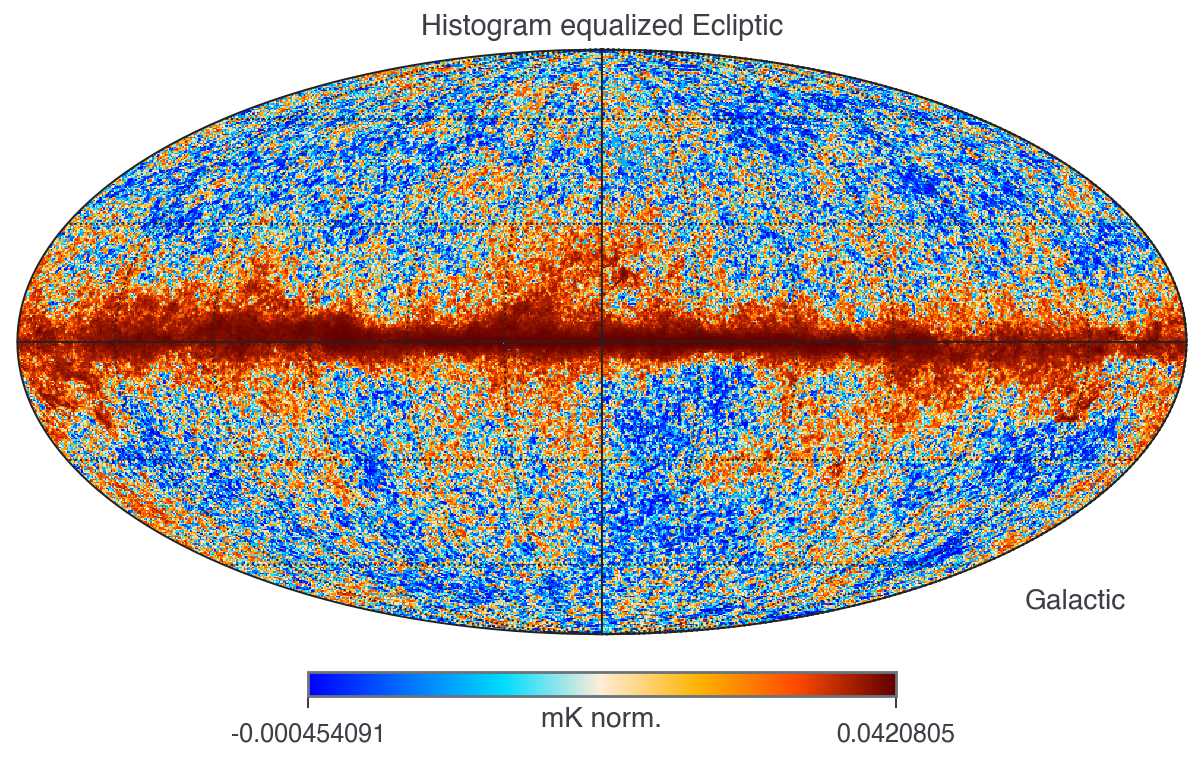

In [12]:
hp.mollview(sky_hm2, coord=["G"],  norm="hist",
            title="Histogram equalized Ecliptic", unit="mK norm.", cmap=cmap)
hp.graticule()

## compute spherical harmoncis

In [ ]:
def find_spherical_harmonics(map_table, gp_table, ps_table, apply_mask=True,
                             stoke_param ='I_STOKES', galactic_plane='GAL020', 
                             frequency=143, NSIDE=2048):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    
    # extract stoke parameter (T or I by default) and mask based on galactic plane and point source
    x = map_table[stoke_param]
    
    if apply_mask:
        gp_mask = gp_table[galactic_plane]
        ps_mask = ps_table[f'F{frequency}']
        x_masked = x*gp_mask*ps_mask
    else:
        x_masked = x
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, pol=False, lmax=4000)               # lmax=4000 is a good estimate, default is #*NSIDE-1
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps, apply_mask=False)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps, apply_mask=False)

## compute actual cross power spectrum

In [ ]:
def find_power_spectrum(alm_1, alm_2, bl_1, bl_2,
                        M_ll=1, f_l=1, n_l=0, NSIDE=2048,
                        pseudo_return=False):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    
    start = time.time()
    # compute pseudo power spectrum
    D_l = hp.sphtfunc.alm2cl(alm_1, alm_2)
        
    # now define all the instrument related biases
    bl_1, bl_2 = bl_1.astype(np.float), bl_2.astype(np.float)
    p_l = hp.sphtfunc.pixwin(NSIDE, lmax=len(bl_1)-1)
    
    # calculate actual power spectrum
    C_l = D_l/(p_l**2 * bl_1*bl_2)
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute the cross-power spectrum.')
    
    if pseudo_return:
        return D_l
    else:
        return C_l
    
D_l = find_power_spectrum(a_lm_1, a_lm_2, beamf_hm1, beamf_hm2, pseudo_return=True)

In [ ]:
l = np.arange(len(D_l))
#C_l_binned = l*(l+1)+C_l/(2*np.pi)
galperc = 'X'

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(l, D_l, 'o')
#ax.set_xlim([100,4000])
ax.set_yscale('log')

ax.set_xlabel('l')
#ax.set_ylabel(r'$\frac{l(l-1)}{2\pi} C_l$')
ax.set_ylabel(r'$D_l$')
ax.set_title(f'Cross-Power Spectrum for 143 GHZ and {galperc}% galactic plane coverage')

plt.show()